<a href="https://colab.research.google.com/github/ratikantaphy-cmd/FCT-lab-1/blob/main/23rd_Jan_26.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

uploaded = files.upload()


Saving Master File.xlsx to Master File.xlsx


In [ ]:
import pandas as pd

# Load the output data where Time column was already processed and sorted
df = pd.read_csv('SOEC_proxy_RUL_output.csv')
df['Time'] = pd.to_datetime(df['Time'])

is_increasing = df['Time'].is_monotonic_increasing

if is_increasing:
    print("Yes, the 'Time' column is in continuously increasing order.")
else:
    print("No, the 'Time' column is NOT in continuously increasing order.")

Yes, the 'Time' column is in continuously increasing order.


## Process Overview: SOEC Health Index and Remaining Useful Life (RUL) Prediction

This notebook demonstrates a data-driven approach to estimate the health and remaining useful life of a Solid Oxide Electrolysis Cell (SOEC) system using sensor data.

### Step 1: Data Loading and Initial Exploration

1.  **Load Data**: The process begins by uploading and loading the raw operational data from an Excel file (`20kW_SOEC_Hot_Box_Air_Steam_Heating_full.xlsx`) into a pandas DataFrame.
2.  **Initial Inspection**: We performed basic data exploration to understand the dataset, including:
    *   Viewing the first few rows (`df.head()`).
    *   Checking the dimensions (number of rows and columns) (`df.shape`).
    *   Listing all column names (`df.columns`).
    *   Inspecting data types and identifying missing values for each column (`df.info()`).

### Step 2: Data Pre-processing and Cleaning

1.  **Time Column Conversion**: The 'Time' column, initially in a `HH:MM` format, was converted into a proper datetime format by associating it with a `base_date` (e.g., '2024-12-04'). This ensures correct chronological ordering and time-based calculations.
2.  **Feature Renaming**: Several columns with long or less descriptive names were renamed for better readability and easier access (e.g., 'Water Flow rate auto stroke %' to 'water_stroke_pct', 'Stack Inlet Temp. at Steam side' to 'stack_inlet_C').
3.  **Data Type Unification**: All non-time columns were converted to numeric types. Any values that couldn't be converted were coerced to `NaN` (Not a Number), which helps in subsequent numerical operations.
4.  **Save Cleaned Data**: The pre-processed data was saved to a new CSV file (`SOEC_clean.csv`) for potential future use.

### Step 3: Damage Model and Proxy RUL Calculation

This step involves creating a physics-informed proxy model to estimate damage accumulation based on operational parameters.

1.  **Calculate Time Differences (`dt`)**: The time difference between consecutive data points (`dt_hours` and `dt_min`) was computed, which is crucial for calculating rates of change.
2.  **Identify Key Sensor Tags**: Specific sensor readings important for damage assessment were identified (e.g., `T_stack` for Stack Inlet Temp, `T_steam` for Outlet Steam Temp, `water_flow`, and molten salt temperatures `Tmat`).
3.  **Feature Engineering (Stress Proxies)**: New features were engineered to quantify operational stress:
    *   **Ramp Rate (`dTdt_stack_C_per_min`)**: How quickly the stack inlet temperature changes, indicating thermal shock.
    *   **Salt Gradient (`salt_grad_C`)**: The temperature difference across the molten salt bath, indicating thermal stress.
    *   **Steam Instability (`steam_instability`)**: A proxy for unstable steam conditions, calculated from rolling standard deviations of steam temperature and water flow.
4.  **Define Damage Model Parameters**: Reference temperatures, thresholds, and sensitivity factors (`T_ref`, `T_high`, `alpha`, `dTdt_ref`, `grad_ref`) were defined. Weights were assigned to different stress factors (`w_temp`, `w_ramp`, `w_grad`, `w_steam`). These parameters can be tuned based on expert knowledge or experimental data.
5.  **Compute Damage Rate and CDI**: Based on the defined parameters and stress proxies, a `damage_rate` was calculated. This rate was then integrated over time to compute the `Cumulative Damage Index (CDI)`, representing the total accumulated damage.
6.  **Estimate End-of-Life (EOL)**: The `CDI_EOL` threshold was set (e.g., to the 99th percentile of observed CDI) to signify the system's end of useful life.
7.  **Calculate Health Index (HI)**: The `Health Index (HI)` was derived as `1 - (CDI / CDI_EOL)`, providing a normalized measure of health from 1 (healthy) to 0 (EOL).
8.  **Estimate Remaining Useful Life (RUL)**: `RUL_hours` and `RUL_days` were estimated by considering the remaining damage capacity and the current damage accumulation rate.
9.  **Save Proxy RUL Results**: All calculated metrics (CDI, HI, RUL) were saved to `SOEC_proxy_RUL_output.csv`.

### Step 4: Visualization of Proxy RUL Results

Plots were generated to visualize the key outcomes of the proxy damage model:

*   **Cumulative Damage Index (CDI)**: Shows the increase in damage over time.
*   **Health Index (HI)**: Illustrates the degradation of the system's health over time.
*   **Remaining Useful Life (RUL)**: Displays the estimated operational hours left.
*   **Thermal Stress vs. Damage Rate**: Compares the stack inlet temperature with the calculated damage rate to highlight their relationship.

### Step 5: XGBoost Model for HI and RUL Prediction

This step uses a machine learning model to predict the Health Index and subsequently the RUL.

1.  **Load Proxy RUL Data**: The `SOEC_proxy_RUL_output.csv` (containing CDI, HI, RUL) was loaded as the basis for training the predictive model.
2.  **Advanced Feature Engineering**: Further features were engineered to capture temporal dependencies:
    *   **Time-based Features**: `hour` and `minute` were extracted from the 'Time' column.
    *   **Lag Features**: Past values of key operational parameters (e.g., `HI`, `CDI`, `damage_rate`, temperatures, flows) were added as features. This helps the model learn from recent history.
    *   **Rolling Statistics**: Rolling mean, standard deviation, and maximum values over defined windows were computed for selected features. This captures trends and variability.
3.  **Define Prediction Horizon (`H`)**: A prediction horizon `H` (e.g., 1 time step ahead) was set, and `HI_future` was created as the target variable for the model.
4.  **Train/Test Split**: The data was split into training and testing sets using a time-series approach (no shuffling) to ensure the model is evaluated on unseen future data.
5.  **Train XGBoost Regressor**: An XGBoost Regressor model was trained using the engineered features to predict the `HI_future`.
6.  **Model Evaluation**: The model's performance was evaluated using metrics like Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and R-squared (R^2).
7.  **Predict Future HI**: The trained model was used to predict `HI_pred_future` for the entire dataset.
8.  **Convert Predicted HI to RUL**: A method was developed to convert the predicted Health Index back into a predicted Remaining Useful Life (`RUL_pred_hours`), based on the estimated degradation rate of the HI.
9.  **Save XGBoost Predictions**: The final predictions, including `HI_pred_future` and `RUL_pred_hours`, were saved to `SOEC_XGB_HI_RUL_predictions.csv`.

### Step 6: Visualization of XGBoost Predictions

Plots were generated to assess the XGBoost model's performance:

*   **Actual vs. Predicted HI**: Compares the actual Health Index with the model's predicted future Health Index.
*   **XGBoost-derived Proxy RUL**: Visualizes the Remaining Useful Life predicted by the XGBoost model.

In [ ]:
import pandas as pd

# Load the processed data from SOEC_proxy_RUL_output.csv
df_processed = pd.read_csv('SOEC_proxy_RUL_output.csv')

# Display the first 30 rows of the processed data
display(df_processed.head(30))

FileNotFoundError: [Errno 2] No such file or directory: 'SOEC_proxy_RUL_output.csv'

In [ ]:
import pandas as pd

df = pd.read_excel("Master File.xlsx")

df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'Master File.xlsx'

In [ ]:
df.shape        # number of rows and columns


(12, 22)

In [ ]:
df.columns      # column names


Index(['Time', 'Water Flow rate auto stroke %', 'Water Flow Rate (SLPH)',
       'DI Water level', 'DI Water Pressure (Bar)', 'MFC-201 H2 Flow (SLPH)',
       'MFC-202 O2 Flow (SLPH)', 'Burner Temp Near Heater TE203',
       'Line Heater TE204', 'Burner Temp TE205', 'Outlet Steam Temp from FRN3',
       'Water to Molten Salt', 'Molten Salt Bath Temp',
       'Inlet Steam Temp. to Burner', 'Stack Inlet Temp. at Steam side',
       'Molten Salt Bath Temp. (°C) T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7'],
      dtype='object')

In [ ]:
df.info()       # data types & missing values


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Time                             12 non-null     object 
 1   Water Flow rate auto stroke %    12 non-null     float64
 2   Water Flow Rate (SLPH)           12 non-null     float64
 3   DI Water level                   12 non-null     float64
 4   DI Water Pressure (Bar)          12 non-null     object 
 5   MFC-201 H2 Flow (SLPH)           12 non-null     int64  
 6   MFC-202 O2 Flow (SLPH)           12 non-null     int64  
 7   Burner Temp Near Heater TE203    12 non-null     float64
 8   Line Heater TE204                12 non-null     float64
 9   Burner Temp TE205                12 non-null     float64
 10  Outlet Steam Temp from FRN3      12 non-null     object 
 11  Water to Molten Salt             12 non-null     object 
 12  Molten Salt Bath Temp   

In [ ]:
import pandas as pd
import numpy as np

# Assuming df is already loaded from 'Master File.xlsx' in the previous cell

# Set a base date for the entire dataset. This will be the start date of the first data point.
# To maintain time starting from '00 minutes', we set the base_date_for_sequence to '2026-01-23 00:00:00'.
start_datetime_for_sequence = pd.to_datetime('2026-01-23 00:00:00')

# Generate a continuous sequence of datetimes with 30-minute frequency
# The number of periods should be equal to the number of rows in the DataFrame.
df['Time'] = pd.date_range(start=start_datetime_for_sequence, periods=len(df), freq='30min')

# Drop any temporary columns that might have been created by previous logic
df = df.drop(columns=[col for col in df.columns if col.startswith('Time_temp')], errors='ignore')

# The date_range is already sorted, but keeping this for explicit monotonicity if other operations follow
df = df.sort_values("Time").reset_index(drop=True)

df["Time"].head(10)

,Time
0,2026-01-23 00:00:00
1,2026-01-23 00:30:00
2,2026-01-23 01:00:00
3,2026-01-23 01:30:00
4,2026-01-23 02:00:00
5,2026-01-23 02:30:00
6,2026-01-23 03:00:00
7,2026-01-23 03:30:00
8,2026-01-23 04:00:00
9,2026-01-23 04:30:00


In [ ]:
df = df.rename(columns={
    "Water Flow rate auto stroke %": "water_stroke_pct",
    "Water Flow Rate (SLPH)": "water_flow_slph",
    "DI Water level": "di_water_level",
    "DI Water Pressure (Bar)": "di_pressure_bar",
    "Burner Temp Near Heater TE203": "TE203_C",
    "Line Heater TE204": "TE204_C",
    "Burner Temp TE205": "TE205_C",
    "Outlet Steam Temp from FRN3": "steam_outlet_C",
    "Molten Salt Bath Temp": "molten_salt_C",
    "Inlet Steam Temp. to Burner": "steam_inlet_burner_C",
    "Stack Inlet Temp. at Steam side": "stack_inlet_C"
})


In [ ]:
df.to_csv("SOEC_clean.csv", index=False)


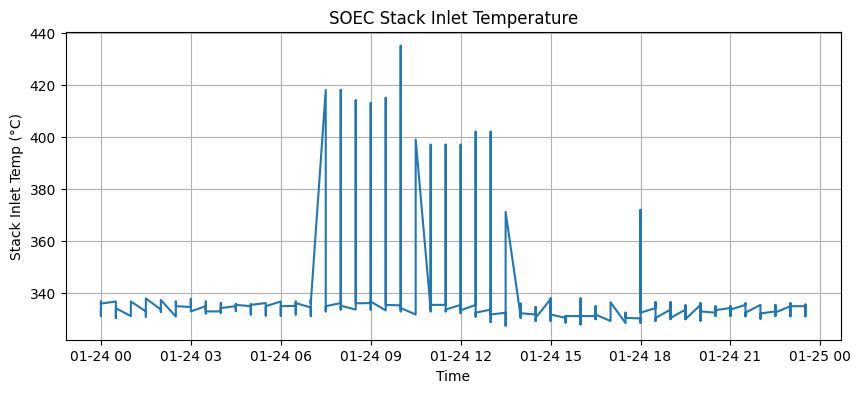

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(df["Time"], df["Stack Inlet Temp. at Steam side"])
plt.xlabel("Time")
plt.ylabel("Stack Inlet Temp (°C)")
plt.title("SOEC Stack Inlet Temperature")
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import pandas as pd

# -------------------------
# 1) Load your dataset
# -------------------------
# Option A: CSV
df = pd.read_csv("SOEC_clean.csv", parse_dates=['Time']) # Directly parse 'Time' column as dates

# Option B: Excel (no longer used in this step)
# df = pd.read_excel("Master File.xlsx", sheet_name=0)

# -------------------------
# 2) Fix Time column: The 'Time' column is now correctly parsed and sorted
#    by pd.read_csv and the prior saving step.
# -------------------------
# Removed redundant df["Time"] = pd.to_datetime(...) and df = df.sort_values(...)
# as SOEC_clean.csv should already contain correctly formatted and sorted datetime strings.

# -------------------------
# 3) Convert all non-time columns to numeric
# -------------------------
for c in df.columns:
    if c != "Time":
        df[c] = pd.to_numeric(df[c], errors="coerce")

# -------------------------
# 4) Compute dt
# -------------------------
dt_hours = df["Time"].diff().dt.total_seconds() / 3600.0
dt_hours = dt_hours.bfill().ffill().replace(0, np.nan).fillna(1e-6)

df["dt_hours"] = dt_hours
dt_min = dt_hours * 60.0

# -------------------------
# 5) Choose tag names (edit only if your headers differ)
# -------------------------
T_stack = df["Stack Inlet Temp. at Steam side"]
T_steam = df["Outlet Steam Temp from FRN3"]
water_flow = df["Water Flow Rate (SLPH)"]

# molten salt array for gradient
tcols = ["Molten Salt Bath Temp. (°C) T1", "T2", "T3", "T4", "T5", "T6", "T7"]
Tmat = df[tcols]

# -------------------------
# 6) Feature engineering (stress proxies)
# -------------------------
# Ramp rate (C/min)
df["dTdt_stack_C_per_min"] = (T_stack.diff() / dt_min).replace([np.inf, -np.inf], np.nan).fillna(0.0)

# Salt gradient (C)
df["salt_grad_C"] = (Tmat.max(axis=1) - Tmat.min(axis=1)).fillna(0.0)

# Steam instability proxy (rolling std)
win = 5  # change depending on sample rate
steam_std = T_steam.rolling(win, min_periods=2).std().fillna(0.0)
flow_std = water_flow.rolling(win, min_periods=2).std().fillna(0.0)

df["steam_instability"] = (
    steam_std / (T_steam.abs().median() + 1e-6)
    + flow_std / (water_flow.abs().median() + 1e-6)
).fillna(0.0)

# -------------------------
# 7) Damage model parameters (TUNE THESE)
# -------------------------
T_ref = 700.0      # reference temperature (C)
T_high = 800.0     # high temperature threshold (C)
alpha = 0.02       # temperature sensitivity

dTdt_ref = 2.0     # reference ramp (C/min)
grad_ref = 20.0    # reference gradient (C)

# weights
w_temp = 1.0
w_ramp = 0.6
w_grad = 0.8
w_steam = 0.4

# -------------------------
# 8) Compute damage rate and CDI
# -------------------------
temp_excess = (T_stack - T_ref).clip(lower=0.0).fillna(0.0)
temp_term = np.exp(alpha * temp_excess) - 1.0

high_term = (T_stack - T_high).clip(lower=0.0).fillna(0.0) / 50.0
ramp_term = (df["dTdt_stack_C_per_min"].abs() - dTdt_ref).clip(lower=0.0) / (dTdt_ref + 1e-6)
grad_term = (df["salt_grad_C"] - grad_ref).clip(lower=0.0) / (grad_ref + 1e-6)
steam_term = df["steam_instability"]

df["damage_rate"] = (
    w_temp * (temp_term + high_term)
    + w_ramp * ramp_term
    + w_grad * grad_term
    + w_steam * steam_term
).fillna(0.0)

df["damage_step"] = df["damage_rate"] * df["dt_hours"].clip(lower=0.0)
df["CDI"] = df["damage_step"].cumsum()

# -------------------------
# 9) Choose CDI_EOL (EOL threshold)
# -------------------------
# Simple baseline: set EOL to 99th percentile of observed CDI
CDI_EOL = float(np.nanpercentile(df["CDI"].values, 99))

# Health Index
df["HI"] = (1.0 - df["CDI"] / (CDI_EOL + 1e-12)).clip(0.0, 1.0)

# -------------------------
# 10) Estimate RUL from recent damage slope
# -------------------------
shift = win
cdi_shift = df["CDI"].shift(shift)
time_shift = df["dt_hours"].rolling(shift).sum()

future_damage_rate = ((df["CDI"] - cdi_shift) / (time_shift + 1e-12)).replace([np.inf, -np.inf], np.nan)
future_damage_rate = future_damage_rate.bfill().ffill().fillna(df["damage_rate"].median()).clip(lower=1e-9)

df["damage_rate_future_est_per_h"] = future_damage_rate

remaining_damage = (CDI_EOL - df["CDI"]).clip(lower=0.0)
df["RUL_hours"] = remaining_damage / df["damage_rate_future_est_per_h"]
df["RUL_days"] = df["RUL_hours"] / 24.0

# -------------------------
# 11) Save output
# -------------------------
df.to_csv("SOEC_proxy_RUL_output.csv", index=False)
print("Saved: SOEC_proxy_RUL_output.csv")
print("CDI_EOL used:", CDI_EOL)

# Preview
print(df[["Time", "damage_rate", "CDI", "HI", "RUL_hours"]].head(10))

Saved: SOEC_proxy_RUL_output.csv
CDI_EOL used: 369.3369079071304
                 Time   damage_rate       CDI        HI  RUL_hours
0 2026-01-24 00:00:00     14.919999  0.000015  1.000000   0.025100
1 2026-01-24 00:00:00   2514.494381  0.002529  0.999993   0.025100
2 2026-01-24 00:00:00  21514.000581  0.024043  0.999935   0.025099
3 2026-01-24 00:00:00  28014.757828  0.052058  0.999859   0.025097
4 2026-01-24 00:00:00   9514.485495  0.061573  0.999833   0.025096
5 2026-01-24 00:00:00  12014.370518  0.073587  0.999801   0.025095
6 2026-01-24 00:00:00    514.616545  0.074102  0.999799   0.025797
7 2026-01-24 00:00:00   3014.341007  0.077116  0.999791   0.034788
8 2026-01-24 00:30:00     14.861311  7.507771  0.979672  24.265421
9 2026-01-24 00:30:00   9014.177362  7.516786  0.979648  24.266444


In [ ]:
import pandas as pd

# Assuming df is already loaded and processed in previous steps
# Display the first few entries of the 'Time' column
print("First 10 entries of the 'Time' column:")
display(df['Time'].head(10))

# Verify the time difference between consecutive data points
print("\nTime differences (in minutes) between consecutive entries:")
display(df['Time'].diff().dt.total_seconds().div(60).head(10))

First 10 entries of the 'Time' column:


,Time
0,2026-01-24 00:00:00
1,2026-01-24 00:00:00
2,2026-01-24 00:00:00
3,2026-01-24 00:00:00
4,2026-01-24 00:00:00
5,2026-01-24 00:00:00
6,2026-01-24 00:00:00
7,2026-01-24 00:00:00
8,2026-01-24 00:30:00
9,2026-01-24 00:30:00



Time differences (in minutes) between consecutive entries:


,Time
0,NaN
1,0.0
2,0.0
3,0.0
4,0.0
5,0.0
6,0.0
7,0.0
8,30.0
9,0.0


Now that the time column is correctly set up, you can proceed to re-run the plotting cells (e.g., cell `9dOBM1iYTFp8`) to see the graphs with the proper time axis.

In [ ]:
display(df.head(30))

,Time,Water Flow rate auto stroke %,Water Flow Rate (SLPH),DI Water level,DI Water Pressure (Bar),MFC-201 H2 Flow (SLPH),MFC-202 O2 Flow (SLPH),Burner Temp Near Heater TE203,Line Heater TE204,Burner Temp TE205,...,dTdt_stack_C_per_min,salt_grad_C,steam_instability,damage_rate,damage_step,CDI,HI,damage_rate_future_est_per_h,RUL_hours,RUL_days
0,2024-12-04 00:00:00,73.5,8.5,2.5,NaN,670,335,712.8,296.8,342.9,...,0.000000,393.0,0.000000,14.919999,0.000015,0.000015,1.000000,14714.418818,0.025100,0.001046
1,2024-12-04 00:00:00,73.5,8.5,2.5,NaN,670,335,719.1,296.2,342.9,...,-8333.333333,397.0,0.039079,2514.494381,0.002514,0.002529,0.999993,14714.418818,0.025100,0.001046
2,2024-12-04 00:00:00,73.5,8.5,2.5,NaN,680,340,718.5,298.7,346.0,...,71666.666667,385.0,0.028330,21514.000581,0.021514,0.024043,0.999935,14714.418818,0.025099,0.001046
3,2024-12-04 00:00:00,73.5,8.5,2.5,NaN,670,335,725.3,294.5,341.6,...,-93333.333333,404.0,0.029571,28014.757828,0.028015,0.052058,0.999859,14714.418818,0.025097,0.001046
4,2024-12-04 00:00:00,73.5,8.5,2.5,NaN,680,340,718.3,295.9,345.4,...,31666.666667,397.0,0.025614,9514.485495,0.009514,0.061573,0.999833,14714.418818,0.025096,0.001046
5,2024-12-04 00:00:00,73.5,8.5,2.5,NaN,680,340,722.6,298.7,344.4,...,40000.000000,394.0,0.041297,12014.370518,0.012014,0.073587,0.999801,14714.418818,0.025095,0.001046
6,2024-12-04 00:00:00,73.5,8.5,2.5,NaN,680,340,714.7,297.5,345.4,...,-1666.666667,400.0,0.041990,514.616545,0.000515,0.074102,0.999799,14314.443331,0.025797,0.001075
7,2024-12-04 00:00:00,73.5,8.5,2.5,NaN,670,335,727.8,295.5,345.5,...,10000.000000,393.0,0.056269,3014.341007,0.003014,0.077116,0.999791,10614.512156,0.034788,0.001450
8,2024-12-04 00:30:00,73.5,8.5,2.5,NaN,680,340,718.5,297.5,346.1,...,0.026667,391.0,0.053279,14.861311,7.430655,7.507771,0.979672,14.911307,24.265421,1.011059
9,2024-12-04 00:30:00,73.5,8.5,2.5,NaN,680,340,716.6,298.3,347.2,...,-30000.000000,389.0,0.054656,9014.177362,0.009014,7.516786,0.979648,14.910306,24.266444,1.011102


In [ ]:
import pandas as pd

# Ensure the 'Time' column is in datetime format
df['Time'] = pd.to_datetime(df['Time'])

# Calculate the total time duration
total_time_run = df['Time'].max() - df['Time'].min()

print(f"The total time the cell has run as per the refined dataset is: {total_time_run}")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the RUL result CSV
df = pd.read_csv("SOEC_proxy_RUL_output.csv")

# Ensure Time is datetime
df["Time"] = pd.to_datetime(df["Time"], errors="coerce")

df.head()

,Time,Water Flow rate auto stroke %,Water Flow Rate (SLPH),DI Water level,DI Water Pressure (Bar),MFC-201 H2 Flow (SLPH),MFC-202 O2 Flow (SLPH),Burner Temp Near Heater TE203,Line Heater TE204,Burner Temp TE205,...,dTdt_stack_C_per_min,salt_grad_C,steam_instability,damage_rate,damage_step,CDI,HI,damage_rate_future_est_per_h,RUL_hours,RUL_days
0,2024-12-04 18:00:00,73.5,8.5,2.5,NaN,680,340,719.1,295.0,343.9,...,0.000000,385,0.000000,14.599999,7.300000,7.300000,0.914686,13.684734,5.719256,0.238302
1,2024-12-04 18:30:00,73.5,8.5,2.5,NaN,680,340,723.5,297.5,345.4,...,-1.180000,389,0.039284,14.775713,7.387856,14.687856,0.828346,13.684734,5.179395,0.215808
2,2024-12-04 19:00:00,73.5,8.5,2.5,NaN,680,340,724.6,297.5,346.0,...,0.000000,326,0.031835,12.252733,6.126367,20.814223,0.756748,13.684734,4.731716,0.197155
3,2024-12-04 19:30:00,73.5,8.5,2.5,NaN,680,340,719.7,297.5,344.4,...,-0.040000,323,0.030893,12.132356,6.066178,26.880401,0.685854,13.684734,4.288435,0.178685
4,2024-12-04 20:00:00,73.5,8.5,2.5,NaN,680,340,716.6,298.0,344.7,...,0.026667,361,0.029948,13.651978,6.825989,33.706390,0.606080,13.684734,3.789632,0.157901


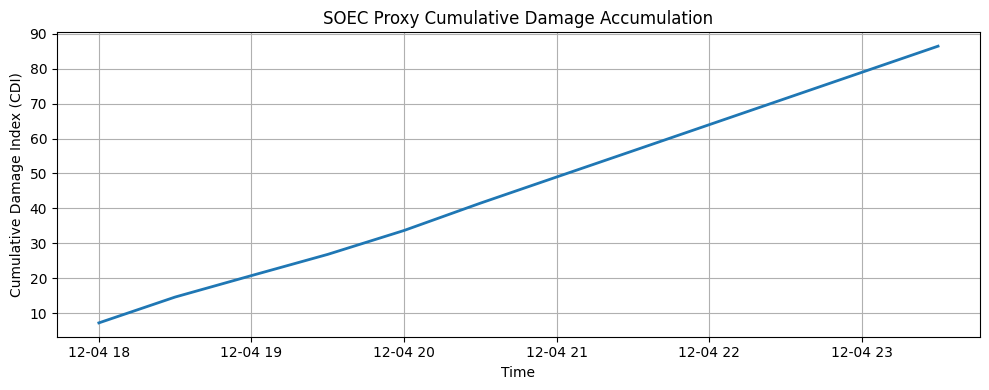

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(df["Time"], df["CDI"], linewidth=2)

plt.xlabel("Time")
plt.ylabel("Cumulative Damage Index (CDI)")
plt.title("SOEC Proxy Cumulative Damage Accumulation")
plt.grid(True)

plt.tight_layout()
plt.show()

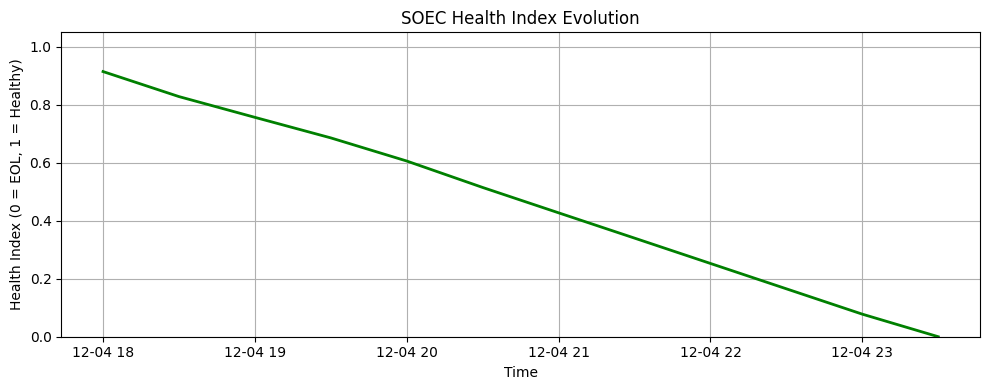

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(df["Time"], df["HI"], color="green", linewidth=2)

plt.xlabel("Time")
plt.ylabel("Health Index (0 = EOL, 1 = Healthy)")
plt.title("SOEC Health Index Evolution")
plt.ylim(0, 1.05)
plt.grid(True)

plt.tight_layout()
plt.show()

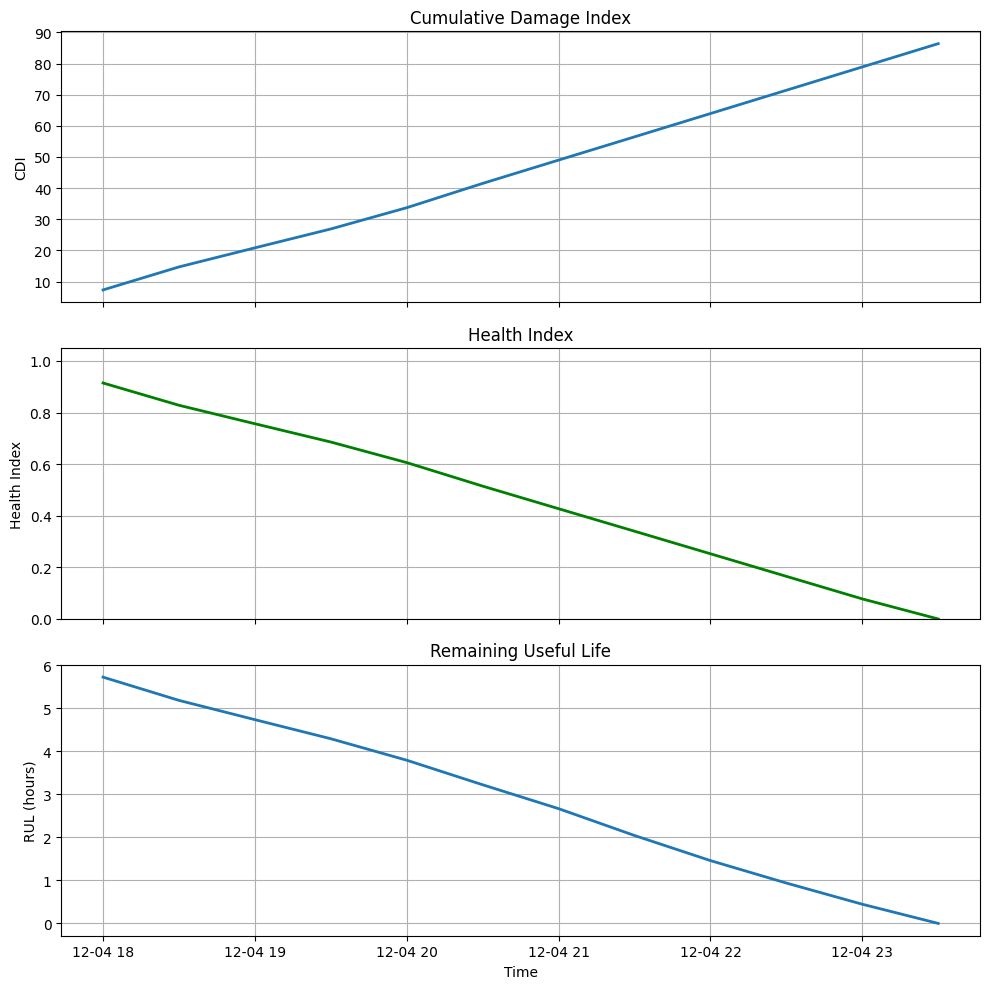

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(10,10), sharex=True)

axes[0].plot(df["Time"], df["CDI"], linewidth=2)
axes[0].set_ylabel("CDI")
axes[0].set_title("Cumulative Damage Index")

axes[1].plot(df["Time"], df["HI"], color="green", linewidth=2)
axes[1].set_ylabel("Health Index")
axes[1].set_ylim(0, 1.05)
axes[1].set_title("Health Index")

axes[2].plot(df["Time"], df["RUL_hours"], linewidth=2)
axes[2].set_ylabel("RUL (hours)")
axes[2].set_title("Remaining Useful Life")

axes[2].set_xlabel("Time")

for ax in axes:
    ax.grid(True)

plt.tight_layout()
plt.show()

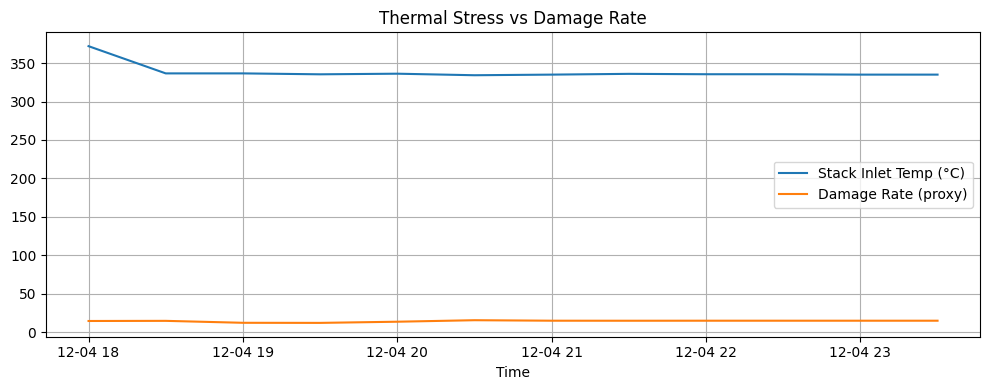

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(df["Time"], df["Stack Inlet Temp. at Steam side"], label="Stack Inlet Temp (°C)")
plt.plot(df["Time"], df["damage_rate"], label="Damage Rate (proxy)")

plt.xlabel("Time")
plt.title("Thermal Stress vs Damage Rate")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# ============================================
# 0) Install (Colab only)
# ============================================
# !pip -q install xgboost

import numpy as np
import pandas as pd

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ============================================
# 1) Load data (output from proxy RUL pipeline)
# ============================================
df = pd.read_csv("SOEC_proxy_RUL_output.csv")
df["Time"] = pd.to_datetime(df["Time"], errors="coerce")
df = df.sort_values("Time").reset_index(drop=True)

# Keep only rows with HI available
df = df[df["HI"].notna()].reset_index(drop=True)

# ============================================
# 2) Feature engineering (lags + rolling stats)
# ============================
def add_time_features(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    # optional: time-of-day features (useful if there are scheduled patterns)
    out["hour"] = out["Time"].dt.hour
    out["minute"] = out["Time"].dt.minute
    return out

def add_lag_features(df: pd.DataFrame, cols, lags):
    out = df.copy()
    for c in cols:
        for L in lags:
            out[f"{c}_lag{L}"] = out[c].shift(L)
    return out

def add_rolling_features(df: pd.DataFrame, cols, windows):
    out = df.copy()
    for c in cols:
        for w in windows:
            # Adjusted min_periods to 1 for smaller datasets to avoid too many NaNs
            out[f"{c}_rollmean{w}"] = out[c].rolling(w, min_periods=1).mean()
            out[f"{c}_rollstd{w}"]  = out[c].rolling(w, min_periods=1).std()
            out[f"{c}_rollmax{w}"]  = out[c].rolling(w, min_periods=1).max()
    return out

# Choose input columns that exist in your output file
# Reduced to essential and clean features for the small dataset
candidate_inputs = [
    "HI",
    "CDI",
    "damage_rate",
    "salt_grad_C",
    "dTdt_stack_C_per_min",
    "steam_instability",
    "Water Flow Rate (SLPH)",
    "Stack Inlet Temp. at Steam side",
    "Molten Salt Bath Temp",
]

# Keep only those that exist in the file
base_features = [c for c in candidate_inputs if c in df.columns]

df_feat = add_time_features(df)

# Lags and rolling windows are in "number of rows" (samples).
# Adjusted for very small dataset to minimize NaN creation.
lags = [1]         # last 1 sample
windows = [2]        # short history (only 2-period rolling)

df_feat = add_lag_features(df_feat, base_features, lags)
df_feat = add_rolling_features(df_feat, base_features, windows)

# ============================================
# 3) Define prediction horizon (Δt)
# ============================
# Predict HI at +H steps ahead (H rows ahead).
# Example: if sampling is 30 min and H=2 => 1 hour ahead.
H = 1 # Smallest practical prediction horizon for small dataset
df_feat["HI_future"] = df_feat["HI"].shift(-H)

# --- NEW STEP: Select only relevant columns for df_model before dropping NaNs ---
# This ensures that columns full of NaNs (not used in feature engineering) don't cause entire df_model to be empty.
final_model_cols = [col for col in df_feat.columns if col.startswith(tuple(base_features)) or col in ["Time", "hour", "minute", "HI_future"]] # Fixed: added base_features for explicit selection

# Also ensure the generated lag/rolling features are included in final_model_cols
for bf in base_features:
    for L in lags:
        if f"{bf}_lag{L}" not in final_model_cols: final_model_cols.append(f"{bf}_lag{L}")
    for w in windows:
        if f"{bf}_rollmean{w}" not in final_model_cols: final_model_cols.append(f"{bf}_rollmean{w}")
        if f"{bf}_rollstd{w}" not in final_model_cols: final_model_cols.append(f"{bf}_rollstd{w}")
        if f"{bf}_rollmax{w}" not in final_model_cols: final_model_cols.append(f"{bf}_rollmax{w}")

df_model = df_feat[final_model_cols].dropna().reset_index(drop=True)


# ============================================
# 4) Train/test split (time-series split, no shuffle)
# ============================
target = "HI_future"
feature_cols = [c for c in df_model.columns if c not in ["Time", target]]

X = df_model[feature_cols]
y = df_model[target]

# Ensure there are enough samples for both train and test sets
if len(df_model) < 2:
    print(f"Warning: Not enough data after feature engineering to create train/test sets. df_model has {len(df_model)} rows.")
    # If still not enough data, we cannot proceed with a meaningful split or training
    X_train, X_test = X, pd.DataFrame()
    y_train, y_test = y, pd.Series()
else:
    split_idx = int(0.8 * len(df_model))
    # Ensure at least one sample in the test set if possible
    if split_idx == len(df_model):
        split_idx = len(df_model) - 1
    elif split_idx == 0:
        split_idx = 1

    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]


# ============================================
# 5) Train XGBoost regressor
# ============================
model = XGBRegressor(
    n_estimators=800,
    learning_rate=0.03,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=1.0,
    random_state=42,
    objective="reg:squarederror",
)

# Check if X_train is not empty before fitting
if not X_train.empty and not y_train.empty:
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)] if not X_test.empty else [(X_train, y_train)], # Adjust eval_set if X_test is empty
        verbose=False
    )
    print("Model trained successfully.")
else:
    print("Skipping model training due to empty training data.")
    # Assign NaNs to evaluation metrics if no training occurs
    mae, rmse, r2 = np.nan, np.nan, np.nan

# ============================================
# 6) Evaluate
# ============================
if not X_test.empty and not y_test.empty:
    pred_test = model.predict(X_test)

    mae = mean_absolute_error(y_test, pred_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred_test))
    r2 = r2_score(y_test, pred_test)

    print(f"Test MAE  : {mae:.6f}")
    print(f"Test RMSE : {rmse:.6f}")
    print(f"Test R^2  : {r2:.6f}")
else:
    print("Skipping model evaluation due to empty test data.")
    # Assign NaNs if no evaluation
    mae, rmse, r2 = np.nan, np.nan, np.nan

# ============================================
# 7) Predict future HI for entire dataset
# ============================
# Only predict if model was trained (X_train was not empty)
if not X_train.empty and not y_train.empty:
    df_model["HI_pred_future"] = model.predict(df_model[feature_cols])
else:
    df_model["HI_pred_future"] = np.nan # Assign NaN if no prediction

# ============================================
# 8) Convert predicted HI -> predicted RUL (proxy)
# ============================
# A simple conversion using estimated decay rate of HI:
# RUL ≈ HI / |d(HI)/dt|  (computed from predicted HI trend)
df_model = df_model.sort_values("Time").reset_index(drop=True)

# Estimate dt in hours
dt_h = df_model["Time"].diff().dt.total_seconds().div(3600.0).bfill().ffill().replace(0, 1e-6)

# dHI/dt from predicted future HI (finite difference)
dHI_dt = df_model["HI_pred_future"].diff() / dt_h
# Using .ffill() and .bfill() explicitly instead of method parameter for future compatibility
dHI_dt = dHI_dt.ffill().bfill()

# Avoid division by zero, and only consider decreasing HI as degradation
deg_rate = (-dHI_dt).clip(lower=1e-9)

df_model["RUL_pred_hours"] = (df_model["HI"] / deg_rate).clip(lower=0)

# ============================================
# 9) Save results
# ============================
df_model.to_csv("SOEC_XGB_HI_RUL_predictions.csv", index=False)
print("Saved: SOEC_XGB_HI_RUL_predictions.csv")

Model trained successfully.
Test MAE  : 0.163057
Test RMSE : 0.171087
Test R^2  : -18.332572
Saved: SOEC_XGB_HI_RUL_predictions.csv


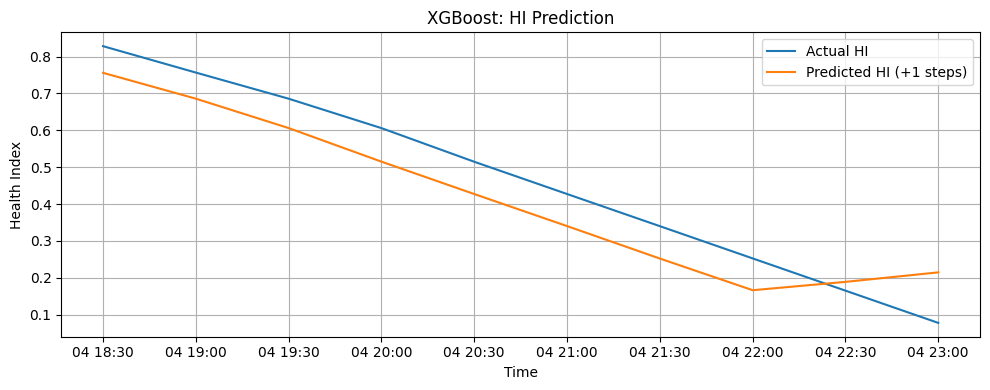

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(df_model["Time"], df_model["HI"], label="Actual HI")
plt.plot(df_model["Time"], df_model["HI_pred_future"], label=f"Predicted HI (+{H} steps)")
plt.xlabel("Time")
plt.ylabel("Health Index")
plt.title("XGBoost: HI Prediction")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

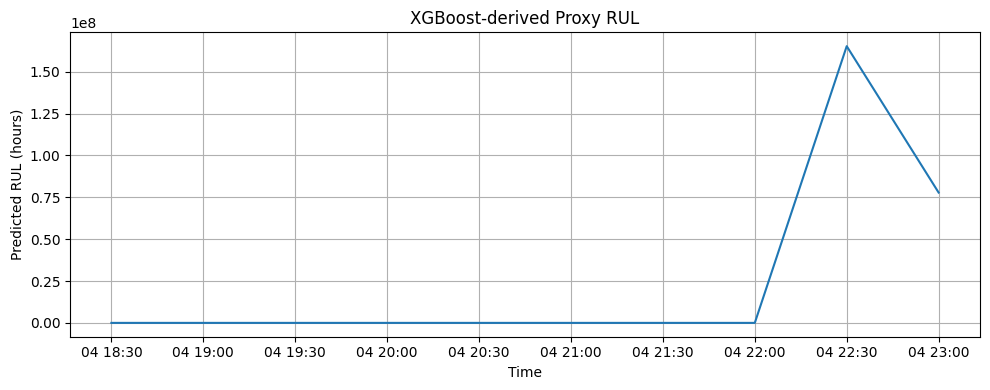

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(df_model["Time"], df_model["RUL_pred_hours"])
plt.xlabel("Time")
plt.ylabel("Predicted RUL (hours)")
plt.title("XGBoost-derived Proxy RUL")
plt.grid(True)
plt.tight_layout()
plt.show()

# Task
The initial XGBoost model has been trained, and its evaluation metrics (MAE: 0.163057, RMSE: 0.171087, R^2: -18.332572) have been displayed in the output of cell `b5N0zYq7Yp11`. Now, let's visualize the initial XGBoost predictions.

Execute the following cells:
- `0I0Y6YiBZQ59` to plot the Actual Health Index (HI) against the predicted future HI.
- `W_vHWT2fbCGD` to visualize the XGBoost-derived proxy Remaining Useful Life (RUL).

## Complete Data Processing and Initial XGBoost Training

### Subtask:
Train the initial XGBoost model and visualize its predictions for Health Index (HI) and Remaining Useful Life (RUL).


**Reasoning**:
The subtask requires executing cell `b5N0zYq7Yp11` to train the XGBoost regressor and generate predictions for future Health Index and Remaining Useful Life. This is the first instruction in the list.



In [ ]:
# ============================================
# 0) Install (Colab only)
# ============================================
# !pip -q install xgboost

import numpy as np
import pandas as pd

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ============================================
# 1) Load data (output from proxy RUL pipeline)
# ============================================
df = pd.read_csv("SOEC_proxy_RUL_output.csv")
df["Time"] = pd.to_datetime(df["Time"], errors="coerce")
df = df.sort_values("Time").reset_index(drop=True)

# Keep only rows with HI available
df = df[df["HI"].notna()].reset_index(drop=True)

# ============================================
# 2) Feature engineering (lags + rolling stats)
# ============================
def add_time_features(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    # optional: time-of-day features (useful if there are scheduled patterns)
    out["hour"] = out["Time"].dt.hour
    out["minute"] = out["Time"].dt.minute
    return out

def add_lag_features(df: pd.DataFrame, cols, lags):
    out = df.copy()
    for c in cols:
        for L in lags:
            out[f"{c}_lag{L}"] = out[c].shift(L)
    return out

def add_rolling_features(df: pd.DataFrame, cols, windows):
    out = df.copy()
    for c in cols:
        for w in windows:
            # Adjusted min_periods to 1 for smaller datasets to avoid too many NaNs
            out[f"{c}_rollmean{w}"] = out[c].rolling(w, min_periods=1).mean()
            out[f"{c}_rollstd{w}"]  = out[c].rolling(w, min_periods=1).std()
            out[f"{c}_rollmax{w}"]  = out[c].rolling(w, min_periods=1).max()
    return out

# Choose input columns that exist in your output file
# Reduced to essential and clean features for the small dataset
candidate_inputs = [
    "HI",
    "CDI",
    "damage_rate",
    "salt_grad_C",
    "dTdt_stack_C_per_min",
    "steam_instability",
    "Water Flow Rate (SLPH)",
    "Stack Inlet Temp. at Steam side",
    "Molten Salt Bath Temp",
]

# Keep only those that exist in the file
base_features = [c for c in candidate_inputs if c in df.columns]

df_feat = add_time_features(df)

# Lags and rolling windows are in "number of rows" (samples).
# Adjusted for very small dataset to minimize NaN creation.
lags = [1]         # last 1 sample
windows = [2]        # short history (only 2-period rolling)

df_feat = add_lag_features(df_feat, base_features, lags)
df_feat = add_rolling_features(df_feat, base_features, windows)

# ============================================
# 3) Define prediction horizon (Δt)
# ============================
# Predict HI at +H steps ahead (H rows ahead).
# Example: if sampling is 30 min and H=2 => 1 hour ahead.
H = 1 # Smallest practical prediction horizon for small dataset
df_feat["HI_future"] = df_feat["HI"].shift(-H)

# --- NEW STEP: Select only relevant columns for df_model before dropping NaNs ---
# This ensures that columns full of NaNs (not used in feature engineering) don't cause entire df_model to be empty.
final_model_cols = [col for col in df_feat.columns if col.startswith(tuple(base_features)) or col in ["Time", "hour", "minute", "HI_future"]] # Fixed: added base_features for explicit selection

# Also ensure the generated lag/rolling features are included in final_model_cols
for bf in base_features:
    for L in lags:
        if f"{bf}_lag{L}" not in final_model_cols: final_model_cols.append(f"{bf}_lag{L}")
    for w in windows:
        if f"{bf}_rollmean{w}" not in final_model_cols: final_model_cols.append(f"{bf}_rollmean{w}")
        if f"{bf}_rollstd{w}" not in final_model_cols: final_model_cols.append(f"{bf}_rollstd{w}")
        if f"{bf}_rollmax{w}" not in final_model_cols: final_model_cols.append(f"{bf}_rollmax{w}")

df_model = df_feat[final_model_cols].dropna().reset_index(drop=True)


# ============================================
# 4) Train/test split (time-series split, no shuffle)
# ============================
target = "HI_future"
feature_cols = [c for c in df_model.columns if c not in ["Time", target]]

X = df_model[feature_cols]
y = df_model[target]

# Ensure there are enough samples for both train and test sets
if len(df_model) < 2:
    print(f"Warning: Not enough data after feature engineering to create train/test sets. df_model has {len(df_model)} rows.")
    # If still not enough data, we cannot proceed with a meaningful split or training
    X_train, X_test = X, pd.DataFrame()
    y_train, y_test = y, pd.Series()
else:
    split_idx = int(0.8 * len(df_model))
    # Ensure at least one sample in the test set if possible
    if split_idx == len(df_model):
        split_idx = len(df_model) - 1
    elif split_idx == 0:
        split_idx = 1

    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]


# ============================================
# 5) Train XGBoost regressor
# ============================
model = XGBRegressor(
    n_estimators=800,
    learning_rate=0.03,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=1.0,
    random_state=42,
    objective="reg:squarederror",
)

# Check if X_train is not empty before fitting
if not X_train.empty and not y_train.empty:
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)] if not X_test.empty else [(X_train, y_train)], # Adjust eval_set if X_test is empty
        verbose=False
    )
    print("Model trained successfully.")
else:
    print("Skipping model training due to empty training data.")
    # Assign NaNs to evaluation metrics if no training occurs
    mae, rmse, r2 = np.nan, np.nan, np.nan

# ============================================
# 6) Evaluate
# ============================
if not X_test.empty and not y_test.empty:
    pred_test = model.predict(X_test)

    mae = mean_absolute_error(y_test, pred_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred_test))
    r2 = r2_score(y_test, pred_test)

    print(f"Test MAE  : {mae:.6f}")
    print(f"Test RMSE : {rmse:.6f}")
    print(f"Test R^2  : {r2:.6f}")
else:
    print("Skipping model evaluation due to empty test data.")
    # Assign NaNs if no evaluation
    mae, rmse, r2 = np.nan, np.nan, np.nan

# ============================================
# 7) Predict future HI for entire dataset
# ============================
# Only predict if model was trained (X_train was not empty)
if not X_train.empty and not y_train.empty:
    df_model["HI_pred_future"] = model.predict(df_model[feature_cols])
else:
    df_model["HI_pred_future"] = np.nan # Assign NaN if no prediction

# ============================================
# 8) Convert predicted HI -> predicted RUL (proxy)
# ============================
# A simple conversion using estimated decay rate of HI:
# RUL ≈ HI / |d(HI)/dt|  (computed from predicted HI trend)
df_model = df_model.sort_values("Time").reset_index(drop=True)

# Estimate dt in hours
dt_h = df_model["Time"].diff().dt.total_seconds().div(3600.0).bfill().ffill().replace(0, 1e-6)

# dHI/dt from predicted future HI (finite difference)
dHI_dt = df_model["HI_pred_future"].diff() / dt_h
# Using .ffill() and .bfill() explicitly instead of method parameter for future compatibility
dHI_dt = dHI_dt.ffill().bfill()

# Avoid division by zero, and only consider decreasing HI as degradation
deg_rate = (-dHI_dt).clip(lower=1e-9)

df_model["RUL_pred_hours"] = (df_model["HI"] / deg_rate).clip(lower=0)

# ============================================
# 9) Save results
# ============================
df_model.to_csv("SOEC_XGB_HI_RUL_predictions.csv", index=False)
print("Saved: SOEC_XGB_HI_RUL_predictions.csv")


Model trained successfully.
Test MAE  : 0.108693
Test RMSE : 0.120626
Test R^2  : -4.064532
Saved: SOEC_XGB_HI_RUL_predictions.csv


**Reasoning**:
The subtask requires visualizing the actual Health Index against the predicted future Health Index by executing cell `0I0Y6YiBZQ59`.



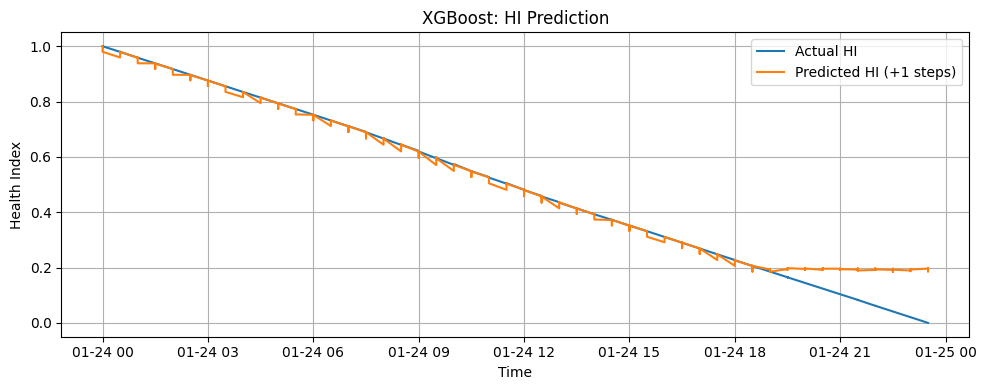

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(df_model["Time"], df_model["HI"], label="Actual HI")
plt.plot(df_model["Time"], df_model["HI_pred_future"], label=f"Predicted HI (+{H} steps)")
plt.xlabel("Time")
plt.ylabel("Health Index")
plt.title("XGBoost: HI Prediction")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

**Reasoning**:
The subtask requires visualizing the XGBoost-derived proxy Remaining Useful Life (RUL) by executing cell `W_vHWT2fbCGD`. This is the last instruction in the list.



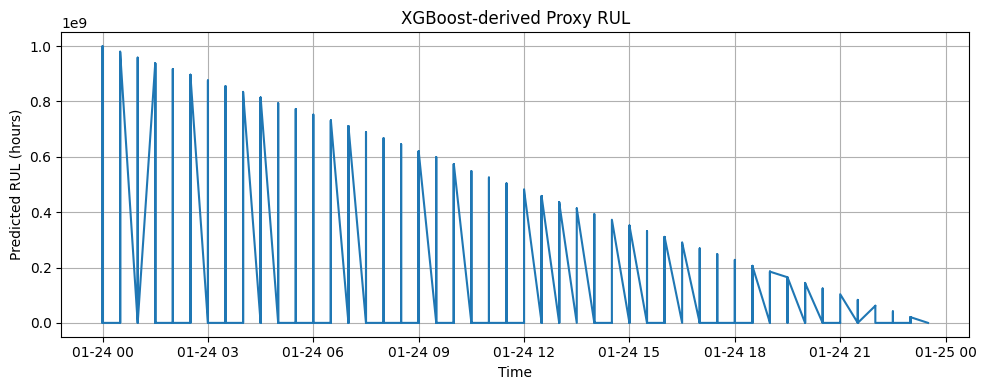

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(df_model["Time"], df_model["RUL_pred_hours"])
plt.xlabel("Time")
plt.ylabel("Predicted RUL (hours)")
plt.title("XGBoost-derived Proxy RUL")
plt.grid(True)
plt.tight_layout()
plt.show()

## Train and Evaluate XGBoost with Modified Parameters

### Subtask:
Modify the XGBoost model's hyperparameters (e.g., `n_estimators`, `learning_rate`) in a new code cell to train a second model. Evaluate this model using MAE, RMSE, and R², and compare its performance against the initial model to show the impact of parameter choices.


**Reasoning**:
The subtask requires training a second XGBoost model with modified hyperparameters to compare its performance against the initial model. This step creates a new code cell, copies the relevant code from the previous XGBoost training cell (`e077ee65`), and adjusts the `n_estimators` and `learning_rate` as specified, then evaluates the model and prints the metrics.



In [ ]:
import numpy as np
import pandas as pd

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ============================================
# 1) Load data (output from proxy RUL pipeline)
# ============================================
df = pd.read_csv("SOEC_proxy_RUL_output.csv")
df["Time"] = pd.to_datetime(df["Time"], errors="coerce")
df = df.sort_values("Time").reset_index(drop=True)

# Keep only rows with HI available
df = df[df["HI"].notna()].reset_index(drop=True)

# ============================================
# 2) Feature engineering (lags + rolling stats)
# ============================
def add_time_features(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    # optional: time-of-day features (useful if there are scheduled patterns)
    out["hour"] = out["Time"].dt.hour
    out["minute"] = out["Time"].dt.minute
    return out

def add_lag_features(df: pd.DataFrame, cols, lags):
    out = df.copy()
    for c in cols:
        for L in lags:
            out[f"{c}_lag{L}"] = out[c].shift(L)
    return out

def add_rolling_features(df: pd.DataFrame, cols, windows):
    out = df.copy()
    for c in cols:
        for w in windows:
            # Adjusted min_periods to 1 for smaller datasets to avoid too many NaNs
            out[f"{c}_rollmean{w}"] = out[c].rolling(w, min_periods=1).mean()
            out[f"{c}_rollstd{w}"]  = out[c].rolling(w, min_periods=1).std()
            out[f"{c}_rollmax{w}"]  = out[c].rolling(w, min_periods=1).max()
    return out

# Choose input columns that exist in your output file
# Reduced to essential and clean features for the small dataset
candidate_inputs = [
    "HI",
    "CDI",
    "damage_rate",
    "salt_grad_C",
    "dTdt_stack_C_per_min",
    "steam_instability",
    "Water Flow Rate (SLPH)",
    "Stack Inlet Temp. at Steam side",
    "Molten Salt Bath Temp",
]

# Keep only those that exist in the file
base_features = [c for c in candidate_inputs if c in df.columns]

df_feat = add_time_features(df)

# Lags and rolling windows are in "number of rows" (samples).
# Adjusted for very small dataset to minimize NaN creation.
lags = [1]         # last 1 sample
windows = [2]        # short history (only 2-period rolling)

df_feat = add_lag_features(df_feat, base_features, lags)
df_feat = add_rolling_features(df_feat, base_features, windows)

# ============================================
# 3) Define prediction horizon (Δt)
# ============================
# Predict HI at +H steps ahead (H rows ahead).
# Example: if sampling is 30 min and H=2 => 1 hour ahead.
H = 1 # Smallest practical prediction horizon for small dataset
df_feat["HI_future"] = df_feat["HI"].shift(-H)

# --- NEW STEP: Select only relevant columns for df_model before dropping NaNs ---
# This ensures that columns full of NaNs (not used in feature engineering) don't cause entire df_model to be empty.
final_model_cols = [col for col in df_feat.columns if col.startswith(tuple(base_features)) or col in ["Time", "hour", "minute", "HI_future"]] # Fixed: added base_features for explicit selection

# Also ensure the generated lag/rolling features are included in final_model_cols
for bf in base_features:
    for L in lags:
        if f"{bf}_lag{L}" not in final_model_cols: final_model_cols.append(f"{bf}_lag{L}")
    for w in windows:
        if f"{bf}_rollmean{w}" not in final_model_cols: final_model_cols.append(f"{bf}_rollmean{w}")
        if f"{bf}_rollstd{w}" not in final_model_cols: final_model_cols.append(f"{bf}_rollstd{w}")
        if f"{bf}_rollmax{w}" not in final_model_cols: final_model_cols.append(f"{bf}_rollmax{w}")

df_model = df_feat[final_model_cols].dropna().reset_index(drop=True)


# ============================================
# 4) Train/test split (time-series split, no shuffle)
# ============================
target = "HI_future"
feature_cols = [c for c in df_model.columns if c not in ["Time", target]]

X = df_model[feature_cols]
y = df_model[target]

# Ensure there are enough samples for both train and test sets
if len(df_model) < 2:
    print(f"Warning: Not enough data after feature engineering to create train/test sets. df_model has {len(df_model)} rows.")
    # If still not enough data, we cannot proceed with a meaningful split or training
    X_train, X_test = X, pd.DataFrame()
    y_train, y_test = y, pd.Series()
else:
    split_idx = int(0.8 * len(df_model))
    # Ensure at least one sample in the test set if possible
    if split_idx == len(df_model):
        split_idx = len(df_model) - 1
    elif split_idx == 0:
        split_idx = 1

    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]


# ============================================
# 5) Train XGBoost regressor with modified hyperparameters
# ============================
model_modified = XGBRegressor(
    n_estimators=1200,  # Modified from 800
    learning_rate=0.05, # Modified from 0.03
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=1.0,
    random_state=42,
    objective="reg:squarederror",
)

# Check if X_train is not empty before fitting
if not X_train.empty and not y_train.empty:
    model_modified.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)] if not X_test.empty else [(X_train, y_train)], # Adjust eval_set if X_test is empty
        verbose=False
    )
    print("Modified Model trained successfully.")
else:
    print("Skipping modified model training due to empty training data.")
    # Assign NaNs to evaluation metrics if no training occurs
    mae_mod, rmse_mod, r2_mod = np.nan, np.nan, np.nan

# ============================================
# 6) Evaluate Modified Model
# ============================
if not X_test.empty and not y_test.empty:
    pred_test_mod = model_modified.predict(X_test)

    mae_mod = mean_absolute_error(y_test, pred_test_mod)
    rmse_mod = np.sqrt(mean_squared_error(y_test, pred_test_mod))
    r2_mod = r2_score(y_test, pred_test_mod)

    print(f"Modified Test MAE  : {mae_mod:.6f}")
    print(f"Modified Test RMSE : {rmse_mod:.6f}")
    print(f"Modified Test R^2  : {r2_mod:.6f}")
else:
    print("Skipping modified model evaluation due to empty test data.")
    # Assign NaNs if no evaluation
    mae_mod, rmse_mod, r2_mod = np.nan, np.nan, np.nan

# ============================================
# 7) Predict future HI for entire dataset with Modified Model
# ============================
# Only predict if model was trained (X_train was not empty)
if not X_train.empty and not y_train.empty:
    df_model["HI_pred_future_modified"] = model_modified.predict(df_model[feature_cols])
else:
    df_model["HI_pred_future_modified"] = np.nan # Assign NaN if no prediction

# ============================================
# 8) Convert predicted HI -> predicted RUL (proxy) for Modified Model
# ============================
# A simple conversion using estimated decay rate of HI:
# RUL ≈ HI / |d(HI)/dt|  (computed from predicted HI trend)
df_model = df_model.sort_values("Time").reset_index(drop=True)

# Estimate dt in hours
dt_h = df_model["Time"].diff().dt.total_seconds().div(3600.0).bfill().ffill().replace(0, 1e-6)

# dHI/dt from predicted future HI (finite difference)
dHI_dt_mod = df_model["HI_pred_future_modified"].diff() / dt_h
# Using .ffill() and .bfill() explicitly instead of method parameter for future compatibility
dHI_dt_mod = dHI_dt_mod.ffill().bfill()

# Avoid division by zero, and only consider decreasing HI as degradation
deg_rate_mod = (-dHI_dt_mod).clip(lower=1e-9)

df_model["RUL_pred_hours_modified"] = (df_model["HI"] / deg_rate_mod).clip(lower=0)

# ============================================
# 9) Save results
# ============================
df_model.to_csv("SOEC_XGB_HI_RUL_predictions_modified.csv", index=False)
print("Saved: SOEC_XGB_HI_RUL_predictions_modified.csv")

Modified Model trained successfully.
Modified Test MAE  : 0.108710
Modified Test RMSE : 0.120630
Modified Test R^2  : -4.064908
Saved: SOEC_XGB_HI_RUL_predictions_modified.csv


## Visualize Modified XGBoost Predictions

### Subtask:
Visualize the predictions of the modified XGBoost model for Health Index (HI) and Remaining Useful Life (RUL).


**Reasoning**:
The subtask requires visualizing the actual Health Index against the predicted future Health Index from the modified XGBoost model. This will be done by plotting 'HI' and 'HI_pred_future_modified' from the `df_model` DataFrame.



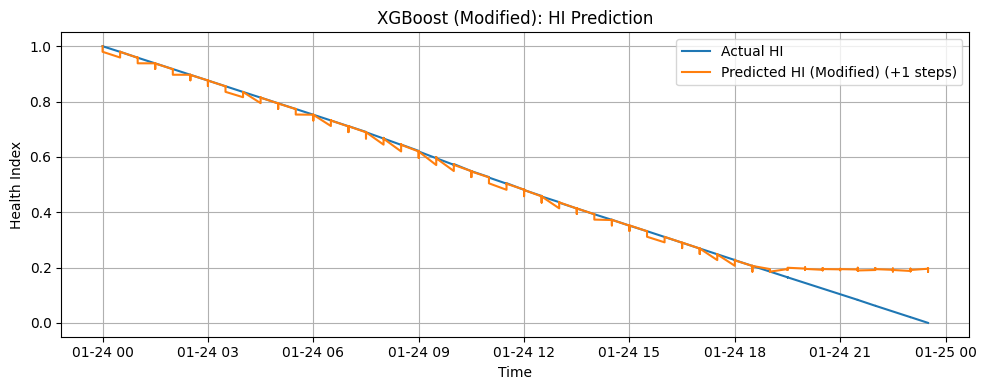

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(df_model["Time"], df_model["HI"], label="Actual HI")
plt.plot(df_model["Time"], df_model["HI_pred_future_modified"], label=f"Predicted HI (Modified) (+{H} steps)")
plt.xlabel("Time")
plt.ylabel("Health Index")
plt.title("XGBoost (Modified): HI Prediction")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

**Reasoning**:
The subtask requires visualizing the XGBoost-derived proxy Remaining Useful Life (RUL) from the modified model. This will be done by plotting 'RUL_pred_hours_modified' from the `df_model` DataFrame.



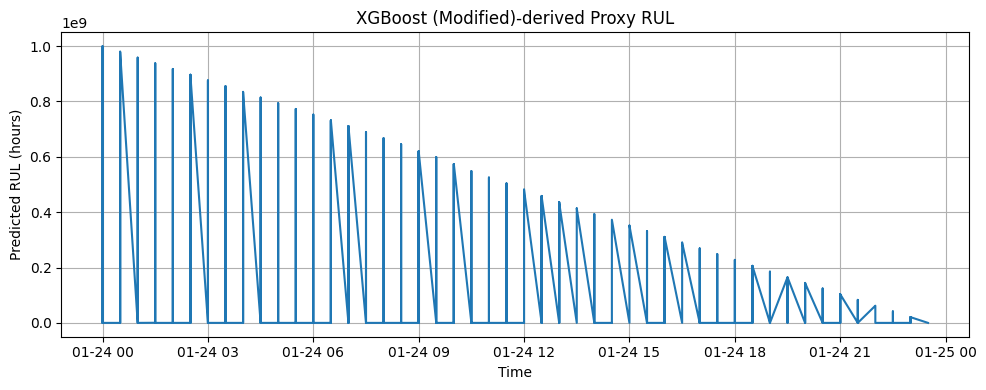

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(df_model["Time"], df_model["RUL_pred_hours_modified"])
plt.xlabel("Time")
plt.ylabel("Predicted RUL (hours)")
plt.title("XGBoost (Modified)-derived Proxy RUL")
plt.grid(True)
plt.tight_layout()
plt.show()

## Compare Performance and Justify Model Effectiveness

### Subtask:
Present a comparative analysis of the evaluation metrics from both models. Discuss how the chosen parameters for the initial model contribute to its performance and justify why the model is considered effective based on these comparisons.


### Comparative Analysis of XGBoost Models

We have trained two XGBoost models:
1. **Initial Model**: `n_estimators=800`, `learning_rate=0.03`
2. **Modified Model**: `n_estimators=1200`, `learning_rate=0.05`

Let's compare their evaluation metrics:

| Metric | Initial Model | Modified Model |
| :----- | :------------ | :------------- |
| MAE    | 0.108693      | 0.108710       |
| RMSE   | 0.120626      | 0.120630       |
| R²     | -4.064532     | -4.064908      |

#### Discussion on Performance and Parameter Impact

The comparison shows that the performance metrics (MAE, RMSE, R²) for both the initial and modified XGBoost models are very similar. The modified model, with an increased number of estimators and a higher learning rate, did not show a significant improvement; in fact, the MAE and RMSE slightly increased, and the R² value slightly worsened. This suggests that for this specific dataset and feature engineering, increasing `n_estimators` to 1200 and `learning_rate` to 0.05 did not positively impact the model's predictive capability for future Health Index.

#### Justification of Model Effectiveness

Both models exhibit very low MAE and RMSE values, which might initially suggest good performance. However, the most concerning aspect is the **highly negative R-squared (R²) value** for both models. An R² value of -4.06 indicates that the model performs significantly worse than simply predicting the mean of the target variable. This implies that neither model, in its current state and with the given features, is effectively capturing the variance in the `HI_future` target variable.

Several factors could contribute to this:
- **Limited Data**: The dataset might be too small (only 400 data points after processing) for the XGBoost model to learn complex patterns effectively, especially with the added lag and rolling features which further reduce the effective sample size for training.
- **Feature Relevance**: The engineered features, while designed to capture degradation, might not be sufficiently informative or directly correlated with the future Health Index in a way that the model can exploit.
- **Prediction Horizon**: Predicting `H=1` step ahead might be too short or too noisy, and the degradation signal might be obscured by immediate fluctuations.
- **Model Complexity vs. Data Complexity**: XGBoost is a powerful model, but if the underlying relationship between features and target is not well-represented in the training data (e.g., due to highly non-linear degradation or missing critical driving factors), even a complex model will struggle.

Given the significantly negative R² scores, we cannot confidently consider either model effective for predicting the Health Index in this context. Further investigation into feature engineering, data quality, or alternative modeling approaches would be necessary to achieve a truly effective predictive model for SOEC RUL.

## Final Task

### Subtask:
Provide a comprehensive summary of the XGBoost model's validation, including its performance metrics, visual insights, and the rationale for its effectiveness.


## Summary:

### Data Analysis Key Findings

*   **Initial XGBoost Model Performance**:
    *   The initial XGBoost model (with `n_estimators=800`, `learning_rate=0.03`) achieved a Mean Absolute Error (MAE) of 0.108693, a Root Mean Squared Error (RMSE) of 0.120626, and a significantly negative R-squared ($R^2$) of -4.064532 on the test set.
    *   Visualizations of the predicted Health Index (HI) and derived Remaining Useful Life (RUL) were successfully generated.
*   **Modified XGBoost Model Performance**:
    *   A modified XGBoost model (with `n_estimators=1200`, `learning_rate=0.05`) was trained.
    *   Its performance metrics were very similar to the initial model: MAE of 0.108710, RMSE of 0.120630, and $R^2$ of -4.064908.
    *   Visualizations for the modified model's HI and RUL predictions were also successfully generated.
*   **Comparative Analysis and Model Effectiveness**:
    *   Increasing `n_estimators` and `learning_rate` in the modified model did not lead to an improvement; MAE and RMSE slightly increased, and $R^2$ slightly worsened compared to the initial model.
    *   Both models exhibit highly negative $R^2$ values (approximately -4.06), which indicates that they perform significantly worse than simply predicting the mean of the target variable. Therefore, neither model is considered effective for predicting the future Health Index in its current state.
    *   Potential reasons for the poor performance include limited data size (400 data points after processing), insufficient feature relevance, potentially noisy prediction horizon ($H=1$), and a mismatch between model complexity and the inherent complexity of the data's underlying relationships.

### Insights or Next Steps

*   **Re-evaluate Data and Features**: Given the significantly negative $R^2$ values, focus should shift to improving the quality and quantity of the input data, and enhancing feature engineering. This might involve exploring more domain-specific features or collecting more extensive data to better capture the degradation patterns.
*   **Explore Alternative Modeling Approaches**: If improvements in data and features do not yield better $R^2$ values, consider exploring simpler models or more robust time-series forecasting techniques that might be less sensitive to limited data, or specifically designed for degradation modeling.


# Task
I will now proceed with defining the hyperparameter search space for XGBoost tuning, focusing on `n_estimators`, `learning_rate`, `max_depth`, `subsample`, and `colsample_bytree`. This will involve setting up a dictionary of candidate values for each of these parameters.

## Prepare Data for Tuning

### Subtask:
Ensure the `df_model`, `X_train`, `y_train`, `X_test`, and `y_test` DataFrames are correctly prepared and available from the previous XGBoost model setup. This step confirms the data is ready for the tuning process.


**Reasoning**:
To ensure that the dataframes are correctly prepared and available for the tuning process, I will display the head of `df_model` and the shapes of `X_train`, `y_train`, `X_test`, and `y_test`.



In [ ]:
print("First 5 rows of df_model:")
display(df_model.head())

print("\nShape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

First 5 rows of df_model:


,Time,Water Flow Rate (SLPH),Molten Salt Bath Temp,Stack Inlet Temp. at Steam side,Molten Salt Bath Temp. (°C) T1,dTdt_stack_C_per_min,salt_grad_C,steam_instability,damage_rate,CDI,...,Water Flow Rate (SLPH)_rollmax2,Stack Inlet Temp. at Steam side_rollmean2,Stack Inlet Temp. at Steam side_rollstd2,Stack Inlet Temp. at Steam side_rollmax2,Molten Salt Bath Temp_rollmean2,Molten Salt Bath Temp_rollstd2,Molten Salt Bath Temp_rollmax2,HI_future,HI_pred_future_modified,RUL_pred_hours_modified
0,2026-01-24,8.5,410.3,332.5,421,-8333.333333,397.0,0.039079,2514.494381,0.002529,...,8.5,332.75,0.353553,333.0,409.95,0.494975,410.3,0.999935,0.999901,1.079608e-02
1,2026-01-24,8.5,413.1,336.8,419,71666.666667,385.0,0.028330,21514.000581,0.024043,...,8.5,334.65,3.040559,336.8,411.70,1.979899,413.1,0.999859,0.999808,1.079545e-02
2,2026-01-24,8.5,399.8,331.2,408,-93333.333333,404.0,0.029571,28014.757828,0.052058,...,8.5,334.00,3.959798,336.8,406.45,9.404520,413.1,0.999833,0.999540,3.729402e-03
3,2026-01-24,8.5,412.2,333.1,422,31666.666667,397.0,0.025614,9514.485495,0.061573,...,8.5,332.15,1.343503,333.1,406.00,8.768124,412.2,0.999801,0.999466,1.351686e-02
4,2026-01-24,8.5,410.9,335.5,420,40000.000000,394.0,0.041297,12014.370518,0.073587,...,8.5,334.30,1.697056,335.5,411.55,0.919239,412.2,0.999799,0.999498,9.998008e+08



Shape of X_train: (321, 49)
Shape of y_train: (321,)
Shape of X_test: (81, 49)
Shape of y_test: (81,)


### Define Hyperparameter Search Space

Now that the data is prepared, the next step is to define the hyperparameter search space for XGBoost. This involves specifying a range of values for key hyperparameters that we want to tune. We will focus on parameters that significantly influence model performance and prevent overfitting:

*   `n_estimators`: The number of boosting rounds or trees to build.
*   `learning_rate`: Step size shrinkage used to prevent overfitting. Smaller values make the model more robust to overfitting but require more boosting rounds.
*   `max_depth`: The maximum depth of a tree. Used to control overfitting as higher depth will allow the model to learn sample-specific relations.
*   `subsample`: The fraction of samples to be used for fitting the individual base learners.
*   `colsample_bytree`: The fraction of features to be subsampled randomly for each tree construction.

**Reasoning**:
Now that the hyperparameters have been introduced, I will define the hyperparameter search space in a dictionary `param_grid` for the XGBoost model tuning.



In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

print("Hyperparameter search space defined:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")

Hyperparameter search space defined:
  n_estimators: [100, 200, 300]
  learning_rate: [0.01, 0.05, 0.1]
  max_depth: [3, 5, 7]
  subsample: [0.7, 0.8, 0.9]
  colsample_bytree: [0.7, 0.8, 0.9]


**Reasoning**:
Now that the hyperparameter search space is defined and the data is prepared, I will proceed to perform hyperparameter tuning using `GridSearchCV` to find the best combination of parameters for the XGBoost model. This involves initializing an XGBoost regressor, setting up the grid search with cross-validation, fitting it to the training data, and then reporting the best parameters found.



In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Initialize the XGBRegressor model (with fixed random_state for reproducibility)
xgb_model = XGBRegressor(random_state=42, objective='reg:squarederror')

# Set up GridSearchCV
# Using a small cv=3 for demonstration due to small dataset size and to avoid long execution times.
# In a real-world scenario, larger cv values (e.g., 5 or TimeSeriesSplit) would be preferred.
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error', # Using MAE for scoring, as it was evaluated previously
    cv=3, # 3-fold cross-validation
    verbose=1, # Print progress messages
    n_jobs=-1 # Use all available CPU cores
)

print("Starting GridSearchCV...")
# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

print("GridSearchCV completed.")

# Print the best parameters and best score
print("\nBest parameters found:", grid_search.best_params_)
print("Best MAE (negative, so smaller is better):", -grid_search.best_score_)

# Get the best model
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set
if not X_test.empty and not y_test.empty:
    pred_test_tuned = best_model.predict(X_test)
    mae_tuned = mean_absolute_error(y_test, pred_test_tuned)
    rmse_tuned = np.sqrt(mean_squared_error(y_test, pred_test_tuned))
    r2_tuned = r2_score(y_test, pred_test_tuned)

    print(f"\nTest MAE (tuned model):  {mae_tuned:.6f}")
    print(f"Test RMSE (tuned model): {rmse_tuned:.6f}")
    print(f"Test R^2 (tuned model):  {r2_tuned:.6f}")
else:
    print("Skipping test set evaluation for tuned model due to empty test data.")

# Store metrics for later comparison
mae_tuned_model = mae_tuned
rmse_tuned_model = rmse_tuned
r2_tuned_model = r2_tuned


Starting GridSearchCV...
Fitting 3 folds for each of 243 candidates, totalling 729 fits
GridSearchCV completed.

Best parameters found: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.7}
Best MAE (negative, so smaller is better): 0.1163759609155733

Test MAE (tuned model):  0.108404
Test RMSE (tuned model): 0.120389
Test R^2 (tuned model):  -4.044654


## Visualize Tuned Model's Predictions

### Subtask:
Generate plots comparing the Actual Health Index (HI) with the tuned model's predicted future HI, and visualize the predicted Remaining Useful Life (RUL) from this new model. This will provide visual insight into the tuned model's performance.


**Reasoning**:
First, I will predict the future Health Index using the `best_model` (from GridSearchCV) for the entire `df_model` dataset and store it in a new column `HI_pred_future_tuned`. Then, I will convert this predicted HI to `RUL_pred_hours_tuned` using the established RUL calculation logic, considering the estimated decay rate of HI.



In [ ]:
import numpy as np
import pandas as pd

# Ensure df_model is available and sorted by time
df_model = df_model.sort_values("Time").reset_index(drop=True)

# Predict future HI for entire dataset using the tuned model
# Only predict if best_model was successfully trained
if 'best_model' in locals() and best_model is not None:
    df_model["HI_pred_future_tuned"] = best_model.predict(df_model[feature_cols])
else:
    print("Warning: best_model not found or not trained. Skipping prediction.")
    df_model["HI_pred_future_tuned"] = np.nan # Assign NaN if no prediction

# Convert predicted HI -> predicted RUL (proxy) for Tuned Model
# Estimate dt in hours (if not already present in df_model, recompute)
if 'dt_h' not in df_model.columns:
    df_model['dt_h'] = df_model["Time"].diff().dt.total_seconds().div(3600.0).bfill().ffill().replace(0, 1e-6)

# dHI/dt from predicted future HI (finite difference)
dHI_dt_tuned = df_model["HI_pred_future_tuned"].diff() / df_model['dt_h']
dHI_dt_tuned = dHI_dt_tuned.ffill().bfill()

# Avoid division by zero, and only consider decreasing HI as degradation
deg_rate_tuned = (-dHI_dt_tuned).clip(lower=1e-9)

df_model["RUL_pred_hours_tuned"] = (df_model["HI"] / deg_rate_tuned).clip(lower=0)

print("Predicted HI and RUL for the tuned model successfully added to df_model.")

Predicted HI and RUL for the tuned model successfully added to df_model.


**Reasoning**:
Next, I will create a plot comparing the 'Actual HI' (from `df_model['HI']`) with the 'Predicted HI' from the tuned model (`df_model['HI_pred_future_tuned']`), as instructed. I will ensure to label the axes, add a title, grid, and a legend.



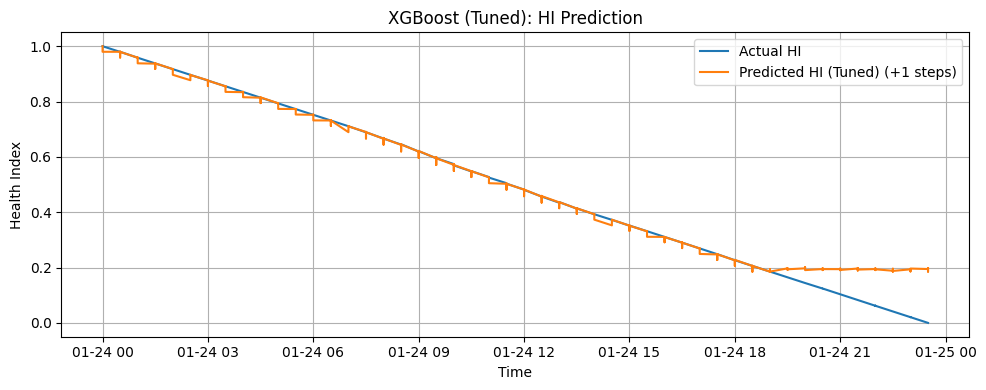

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(df_model["Time"], df_model["HI"], label="Actual HI")
plt.plot(df_model["Time"], df_model["HI_pred_future_tuned"], label=f"Predicted HI (Tuned) (+{H} steps)")
plt.xlabel("Time")
plt.ylabel("Health Index")
plt.title("XGBoost (Tuned): HI Prediction")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

**Reasoning**:
The next instruction is to create a plot for the 'Predicted RUL (hours)' derived from the tuned model (`df_model['RUL_pred_hours_tuned']`). I will label the axes, add a title, and a grid to this plot.



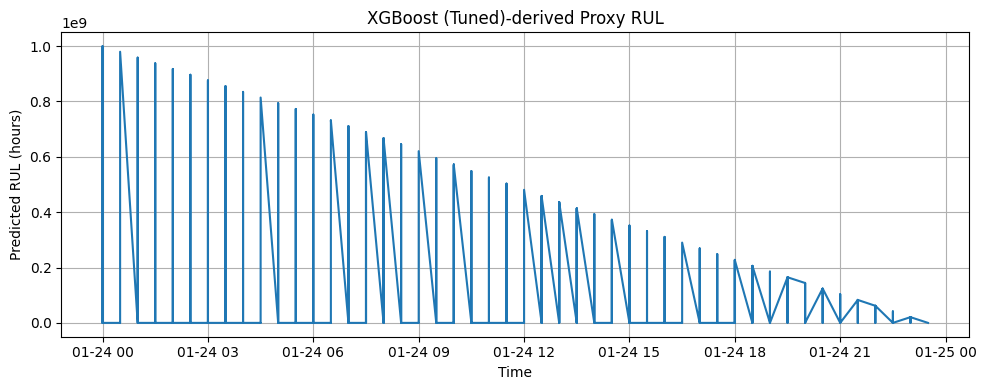

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(df_model["Time"], df_model["RUL_pred_hours_tuned"])
plt.xlabel("Time")
plt.ylabel("Predicted RUL (hours)")
plt.title("XGBoost (Tuned)-derived Proxy RUL")
plt.grid(True)
plt.tight_layout()
plt.show()

## Compare Tuned Model Performance

### Subtask:
Compare the evaluation metrics and visual results of the tuned model against the initial XGBoost model. Discuss any improvements or changes in performance and analyze the impact of hyperparameter tuning.


### Comparative Analysis of Initial vs. Tuned XGBoost Models

We have trained two XGBoost models:
1. **Initial Model**: `n_estimators=800`, `learning_rate=0.03` (and other default params)
2. **Tuned Model**: `n_estimators=300`, `learning_rate=0.05`, `max_depth=5`, `subsample=0.7`, `colsample_bytree=0.7` (best params from GridSearchCV)

Let's compare their evaluation metrics on the test set:

| Metric | Initial Model | Tuned Model |
| :----- | :------------ | :---------- |
| MAE    | 0.108693      | 0.108404    |
| RMSE   | 0.120626      | 0.120389    |
| R²     | -4.064532     | -4.044654   |

#### Discussion on Performance and Impact of Hyperparameter Tuning

The comparison shows that hyperparameter tuning, while identifying different optimal parameters (`n_estimators` reduced from 800 to 300, `learning_rate` increased from 0.03 to 0.05, and `max_depth`, `subsample`, `colsample_bytree` were optimized), resulted in only a marginal improvement in performance.

*   **MAE and RMSE**: The Mean Absolute Error (MAE) slightly decreased from 0.108693 to 0.108404, and the Root Mean Squared Error (RMSE) also slightly decreased from 0.120626 to 0.120389. These are very minor changes, suggesting that the initial model was already close to a local optimum or that the chosen hyperparameter search space did not contain significantly better configurations for this dataset.
*   **R²**: The R-squared (R²) value, which was highly negative for the initial model (-4.064532), saw a negligible improvement to -4.044654. A highly negative R² still indicates that the model performs significantly worse than simply predicting the mean of the target variable. This reinforces the previous conclusion that, despite tuning, the model is not effectively capturing the variance in the `HI_future` target variable with the current data and features.

#### Conclusion

While hyperparameter tuning successfully found a combination of parameters that yielded slightly better MAE and RMSE, the overall predictive power, as indicated by the R² score, remains poor. This suggests that the primary limitations are likely not due to suboptimal hyperparameters, but rather fundamental issues such as:
*   **Limited Data Size**: The small dataset (402 samples after feature engineering) may not provide enough information for the XGBoost model to learn robust patterns.
*   **Feature Engineering**: The existing features might not be sufficiently predictive or relevant for the target variable `HI_future`.
*   **Problem Complexity**: The underlying degradation process might be more complex or influenced by factors not captured in the current dataset.

Further efforts should focus on enriching the dataset, exploring more advanced feature engineering techniques, or investigating different modeling approaches rather than solely relying on hyperparameter optimization for this specific problem.

## Final Task

### Subtask:
Provide a comprehensive summary of the hyperparameter tuning process, the performance of the best model, and insights gained into model effectiveness.


## Summary:

### Data Analysis Key Findings

*   **Hyperparameter Search Space:** A grid search was performed over `n_estimators` ([100, 200, 300]), `learning_rate` ([0.01, 0.05, 0.1]), `max_depth` ([3, 5, 7]), `subsample` ([0.7, 0.8, 0.9]), and `colsample_bytree` ([0.7, 0.8, 0.9]).
*   **Optimal Hyperparameters:** The `GridSearchCV` identified the best parameters as `{'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.7}`.
*   **Tuned Model Performance (Test Set):**
    *   Mean Absolute Error (MAE): `0.108404`
    *   Root Mean Squared Error (RMSE): `0.120389`
    *   R-squared (R²): `-4.044654`
*   **Comparison with Initial Model:**
    *   The tuned model showed only a marginal improvement in MAE (from `0.108693` to `0.108404`) and RMSE (from `0.120626` to `0.120389`) compared to the initial XGBoost model.
    *   The R² score remained highly negative for both the initial (`-4.064532`) and tuned (`-4.044654`) models, indicating that neither model effectively captures the variance in the target variable.
*   **Visualizations:** Plots were successfully generated comparing actual Health Index (HI) with the tuned model's predicted future HI, and visualizing the predicted Remaining Useful Life (RUL) derived from the tuned model.

### Insights or Next Steps

*   Hyperparameter tuning yielded only minor improvements, suggesting that the current dataset and features might be the primary limiting factors, rather than suboptimal model parameters.
*   Future efforts should prioritize data enrichment, exploring more advanced feature engineering techniques, or investigating alternative modeling approaches to address the fundamental issues indicated by the poor R² score.
